In [2]:
!python --version

Python 3.9.13


In [1]:
import os
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torch
from typing import Literal
from PIL import Image
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import matplotlib.pyplot as plt
import cv2
import numpy as np

**Mean and std for image normalization.**

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]

In [31]:
# MEAN = [0.485, 0.456, 0.406]
# STD = [0.229, 0.224, 0.225]

In [3]:
class BCSSDataset(Dataset):
    SIZE=(224, 224)
#     _img_transformer = transforms.Compose([
#             transforms.Resize(SIZE),
#             transforms.PILToTensor(),
#             transforms.ConvertImageDtype(torch.float),
#             transforms.Normalize(mean=MEAN, std=STD),
#         ])
    _mask_transformer = transforms.Compose([
            transforms.Resize(SIZE),
            transforms.PILToTensor(),
        ])
    
    def __init__(self, path: str, split: Literal['train', 'val', 'test'] = 'train'):
        path = os.path.abspath(path)
        image_path = os.path.join(path, split)
        self.images = [os.path.join(image_path, filename) for filename in os.listdir(image_path)]
        mask_path = os.path.join(path, f'{split}_mask')
        self.masks = [os.path.join(mask_path, filename) for filename in os.listdir(mask_path)]

        # TODO: handle test set

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx: int):
#         image = Image.open(self.images[idx])
#         image = self._img_transformer(image)
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = Image.open(self.masks[idx])
        mask = self._mask_transformer(mask)
        mask = torch.squeeze(mask, 0).long()

        return image, mask

In [4]:
NUM_CLASSES = 22
IMAGE_PATH='../data/BCSS'
train_dataset = BCSSDataset(path=IMAGE_PATH, split='train')
val_dataset = BCSSDataset(path=IMAGE_PATH, split='val')

In [5]:
torch.cuda.is_available()

True

In [6]:
batch = 32
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch, shuffle=False)

In [7]:
device = torch.device(
    'cuda:0' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
)

In [8]:
device

device(type='cuda', index=0)

In [9]:
train_dataset[0][0].shape

(224, 224, 3)

In [10]:
train_dataset[0][1]

tensor([[2, 2, 2,  ..., 2, 2, 2],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [2, 2, 2,  ..., 1, 1, 1],
        [2, 2, 2,  ..., 1, 1, 1],
        [2, 2, 2,  ..., 1, 1, 1]])

In [11]:
model_checkpoint="../model_checkpoint/sam_vit_h_4b8939.pth"
sam = sam_model_registry["default"](checkpoint=model_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

In [12]:
masks = mask_generator.generate(train_dataset[0][0])

In [13]:
masks

[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 379,
  'bbox': [204, 55, 19, 23],
  'predicted_iou': 0.9914757609367371,
  'point_coords': [[213.5, 73.5]],
  'stability_score': 0.969072163105011,
  'crop_box': [0, 0, 224, 224]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 657,
  'bbox': [35, 0, 38, 21],
  'pred

In [14]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [15]:
len(masks)

46

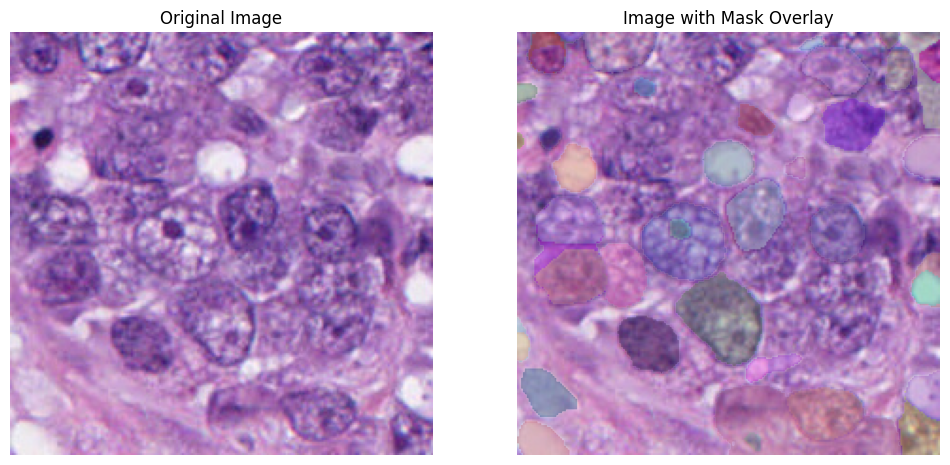

In [16]:
# plt.figure(figsize=(20, 20))
plt.figure(figsize=(12, 6))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(train_dataset[0][0])
plt.title('Original Image')
plt.axis('off')

# Plot image with mask overlay
plt.subplot(1, 2, 2)
plt.imshow(train_dataset[0][0])
show_anns(masks)
plt.title('Image with Mask Overlay')
plt.axis('off')

plt.show()

In [17]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=2,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.50,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [18]:
masks = mask_generator_2.generate(train_dataset[0][0])

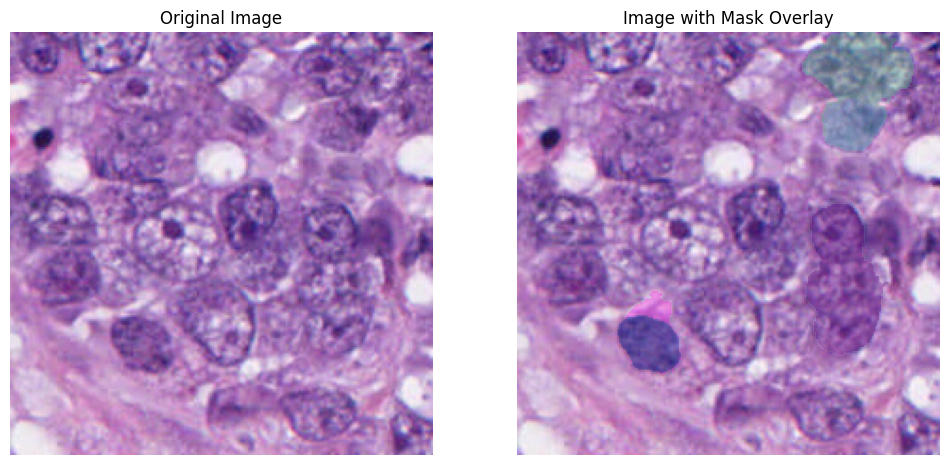

In [19]:
# plt.figure(figsize=(20, 20))
plt.figure(figsize=(12, 6))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(train_dataset[0][0])
plt.title('Original Image')
plt.axis('off')

# Plot image with mask overlay
plt.subplot(1, 2, 2)
plt.imshow(train_dataset[0][0])
show_anns(masks)
plt.title('Image with Mask Overlay')
plt.axis('off')

plt.show()

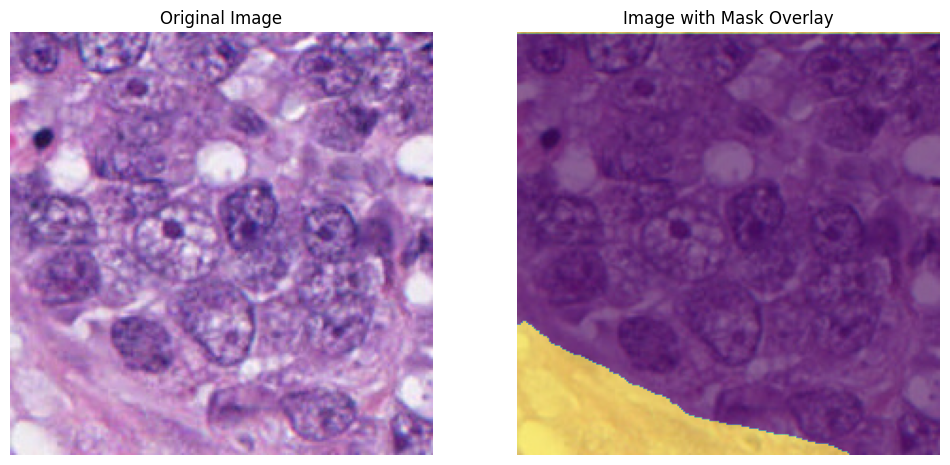

In [20]:
def plot_sample(dataset, idx):
    """
    Plot a sample image and its mask from the dataset.

    Args:
        dataset (Dataset): The custom BCSSDataset instance.
        idx (int): Index of the sample to be plotted.
    """
    image, mask = dataset[idx]
#     image_np = image.permute(1, 2, 0).numpy()  # Convert from PyTorch tensor to numpy array
    mask_np = mask.squeeze().numpy()  # Remove channel dimension and convert to numpy array

    plt.figure(figsize=(12, 6))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Plot image with mask overlay
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(mask_np, alpha=0.6)  # Alpha controls the transparency
    plt.title('Image with Mask Overlay')
    plt.axis('off')

    plt.show()
sample_idx = 0  # You can change this index to visualize different samples
plot_sample(train_dataset, sample_idx)

In [21]:
train_dataset[0][1]

tensor([[2, 2, 2,  ..., 2, 2, 2],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [2, 2, 2,  ..., 1, 1, 1],
        [2, 2, 2,  ..., 1, 1, 1],
        [2, 2, 2,  ..., 1, 1, 1]])

In [ ]:
# image = cv2.imread('data/BCSS/train_mask/TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_0_224_size224.png')

In [ ]:
train_dataset[0][1].squeeze().numpy()

In [ ]:
masks[0]['segmentation']

In [ ]:
from segment_anything import sam_model_registry
from utils.demo import BboxPromptDemo
MedSAM_CKPT_PATH = "model_checkpoint/MedSAM/medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

In [ ]:
%matplotlib widget
class PointPromptDemo:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.image = None
        self.image_embeddings = None
        self.img_size = None


    def show_mask(self, mask, ax, random_color=False, alpha=0.95):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([alpha])], axis=0)
        else:
            color = np.array([251/255, 252/255, 30/255, alpha])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

    @torch.no_grad()
    def infer(self, x, y):
        coords_1024 = np.array([[[
            x * 1024 / self.img_size[1],
            y * 1024 / self.img_size[0]
        ]]])
        coords_torch = torch.tensor(coords_1024, dtype=torch.float32).to(self.model.device)
        labels_torch = torch.tensor([[1]], dtype=torch.long).to(self.model.device)
        point_prompt = (coords_torch, labels_torch)

        sparse_embeddings, dense_embeddings = self.model.prompt_encoder(
            points = point_prompt,
            boxes = None,
            masks = None,
        )
        low_res_logits, _ = self.model.mask_decoder(
            image_embeddings=self.image_embeddings, # (B, 256, 64, 64)
            image_pe=self.model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
        )

        low_res_probs = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)
        low_res_pred = F.interpolate(
            low_res_probs,
            size = self.img_size,
            mode = 'bilinear',
            align_corners = False
        )
        low_res_pred = low_res_pred.detach().cpu().numpy().squeeze()

        seg = np.uint8(low_res_pred > 0.5)

        return seg

    def show(self, fig_size=5, alpha=0.95, scatter_size=10):

        assert self.image is not None, "Please set image first."
        seg = None
        fig, ax = plt.subplots(1, 1, figsize=(fig_size, fig_size))
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = False
        fig.canvas.toolbar_visible = False
        fig.canvas.resizable = False

        plt.tight_layout()

        ax.imshow(self.image)
        ax.axis('off')

        def onclick(event):
            if event.inaxes == ax:
                x, y = float(event.xdata), float(event.ydata)
                with torch.no_grad():
                    ## rescale x, y from canvas size to 1024 x 1024
                    seg = self.infer(x, y)

                ax.clear()
                ax.imshow(self.image)
                ax.axis('off')
                ax.scatter(x, y, c='r', s=scatter_size)
                self.show_mask(seg, ax, random_color=False, alpha=alpha)

                gc.collect()

        fig.canvas.mpl_connect('button_press_event', onclick)
        plt.show()

        save_button = widgets.Button(description="save")
        def __on_save_button_clicked(b):
            plt.savefig("seg_result.png", bbox_inches='tight', pad_inches=0)
            if seg is not None:
                cv2.imwrite("seg.png", seg)
                print(f"Segmentation result saved to {getcwd()}")

        display(save_button)
        save_button.on_click(__on_save_button_clicked)

    def set_image(self, image):
        self.img_size = image.shape[:2]
        if len(image.shape) == 2:
            image = np.repeat(image[:,:,None], 3, -1)
        self.image = image
        image_preprocess = self.preprocess_image(self.image)
        with torch.no_grad():
            self.image_embeddings = self.model.image_encoder(image_preprocess)

    def preprocess_image(self, image):
        img_resize = cv2.resize(
            image,
            (1024, 1024),
            interpolation=cv2.INTER_CUBIC
        )
        # Resizing
        img_resize = (img_resize - img_resize.min()) / np.clip(img_resize.max() - img_resize.min(), a_min=1e-8, a_max=None) # normalize to [0, 1], (H, W, 3
        # convert the shape to (3, H, W)
        assert np.max(img_resize)<=1.0 and np.min(img_resize)>=0.0, 'image should be normalized to [0, 1]'
        img_tensor = torch.tensor(img_resize).float().permute(2, 0, 1).unsqueeze(0).to(self.model.device)

        return img_tensor


In [ ]:
img = "data/BCSS/train/TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_0_224_size224.png"
bbox_prompt_demo = BboxPromptDemo(medsam_model)
bbox_prompt_demo.show(img)